In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

In [2]:
# We are going to be training pretty large models. In order not to face errors, we need
# to set tensorflow option to grow GPU memory allocation when required.

physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Loading datasets

df_train=pd.read_csv('train_news.csv')
df_test=pd.read_csv('test_news.csv')

In [4]:
# Labeling data (changing labels 1..4 for 0..3 for a Dense layer to be within the requested range)

df_train[['Class Index']]=df_train[['Class Index']].replace(to_replace=[1,2,3,4],value=[0,1,2,3])
df_test[['Class Index']]=df_test[['Class Index']].replace(to_replace=[1,2,3,4],value=[0,1,2,3])
# df_train[['Class Index']]=df_train[['Class Index']].replace(to_replace=[0,1,2,3],value=['World', 'Sports', 'Business', 'Sci/Tech'])
# df_test[['Class Index']]=df_test[['Class Index']].replace(to_replace=[0,1,2,3],value=['World', 'Sports', 'Business', 'Sci/Tech'])

In [5]:
# Checking length

print(f"Length of train dataset = {len(df_train)}")
print(f"Length of test dataset = {len(df_test)}")

Length of train dataset = 120000
Length of test dataset = 7600


In [6]:
# Printing train head

df_train.head()

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
df_test.head()

,Class Index,Title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [8]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


(None, None)

In [9]:
df_train['Class Index'].value_counts(), df_test['Class Index'].value_counts()

(2    30000
 3    30000
 1    30000
 0    30000
 Name: Class Index, dtype: int64,
 2    1900
 3    1900
 1    1900
 0    1900
 Name: Class Index, dtype: int64)

In [10]:
# Creating a combined column of Titles and Descriptions

df_train['Combined']=df_train['Title']+' '+df_train['Description']
df_test['Combined']=df_test['Title']+' '+df_test['Description']

In [11]:
# Now we need to convert text into numbers that can be represented as tensors. 
# If we want word-level representation, we need to do two things:
# Use a tokenizer to split text into tokens.
# Build a vocabulary of those tokens.
# Limiting vocabulary size.
# Automatically calculating BoW Vectors 

vocab_size = 50000
vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_mode='count')
vectorizer.adapt(df_train['Combined'])

In [12]:
# Now we can access the actual vocabulary

vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
print(vocab[:10])
print(f"Length of vocabulary: {vocab_size}")

['[UNK]', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for', '39s']
Length of vocabulary: 50000


In [13]:
# Using the vectorizer, we can easily encode any text into a set of numbers

vectorizer("Let's check how it works")

<tf.Tensor: shape=(50000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [28]:
# Checking a model with Term frequency - inverse document frequency (TF-IDF) Vectorizer
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_mode='tf-idf'),
    keras.layers.Dense(4,input_shape=(vocab_size,), activation='softmax')
])

In [29]:
print("Training vectorizer")

model.layers[0].adapt(df_train['Combined'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
history = model.fit(df_train['Combined'].values,df_train['Class Index'].values,
        validation_data=[df_test['Combined'].values,df_test['Class Index'].values],
        epochs=10, verbose=0, batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0)])

Training vectorizer
Epoch 2: early stopping


In [35]:
# evaluate the model

_, train_acc = model.evaluate(df_train['Combined'].values,df_train['Class Index'].values, verbose=0)
_, test_acc = model.evaluate(df_test['Combined'].values,df_test['Class Index'].values, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.974, Test: 0.913


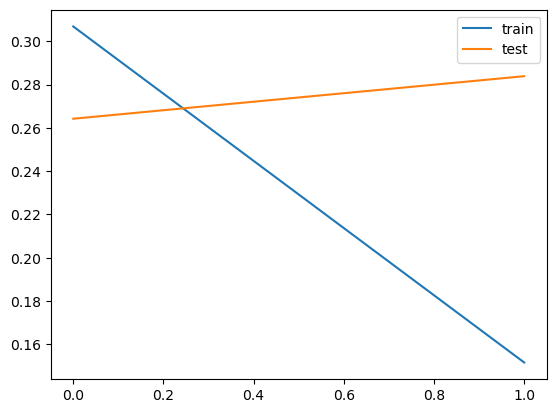

In [30]:
# plot training history

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
# Model prediction for test data
# predictions=model.predict(df_test['Combined'])
# predictions

In [37]:
# Once more checking accuracy for test data (already done for validation data while fitting the model)
# Though the model is very simple, I've managed to get quite a high accuracy
# predictions_max=predictions.argmax(axis=1)
# np.average(df_test['Class Index']==predictions_max)

In [ ]:
stop!

In [ ]:
# Switching from bag-of-words to an embedding bag model as a way to reduce the dimensionality of a word vector

# vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,input_shape=(1,))
# model = keras.models.Sequential([
#     vectorizer,    
#     keras.layers.Embedding(vocab_size,100),
#     keras.layers.Lambda(lambda x: tf.reduce_mean(x,axis=1)),
#     keras.layers.Dense(4, activation='softmax')
# ])
# model.summary()

In [ ]:
# vectorizer.adapt(df_train['Combined'])

# model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'])
# model.fit(df_train['Combined'].values,df_train['Class Index'].values,
#          validation_data=[df_test['Combined'].values,df_test['Class Index'].values])

In [ ]:
stop!

In [38]:
# Using embeddings, LSTM, bidirectional and multilayer RNNs 
# to check if it can improve Accuracy

vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,input_shape=(1,))
model = keras.models.Sequential([
    vectorizer,
    keras.layers.Embedding(vocab_size, 128, mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),    
    keras.layers.Dense(4,activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

In [40]:
# Running the model with batch_size and EarlyStopping monitor

print("Training vectorizer")
vectorizer.adapt(df_train['Combined'])
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='adam')
history1=model.fit(df_train['Combined'].values,df_train['Class Index'].values, batch_size=64,
        epochs=10, verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
        validation_data=[df_test['Combined'].values,df_test['Class Index'].values])

Epoch 1/10
1875/1875 [==============================] - 622s 324ms/step - loss: 0.2757 - acc: 0.9074 - val_loss: 0.2465 - val_acc: 0.9153
Epoch 2/10
1875/1875 [==============================] - 666s 355ms/step - loss: 0.1650 - acc: 0.9437 - val_loss: 0.2615 - val_acc: 0.9136
Epoch 2: early stopping


In [41]:
# evaluate the model - so far, Accuracy improvement for Test dataset is negligible

_, train_acc = model.evaluate(df_train['Combined'].values,df_train['Class Index'].values, verbose=1)
_, test_acc = model.evaluate(df_test['Combined'].values,df_test['Class Index'].values, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.964, Test: 0.914


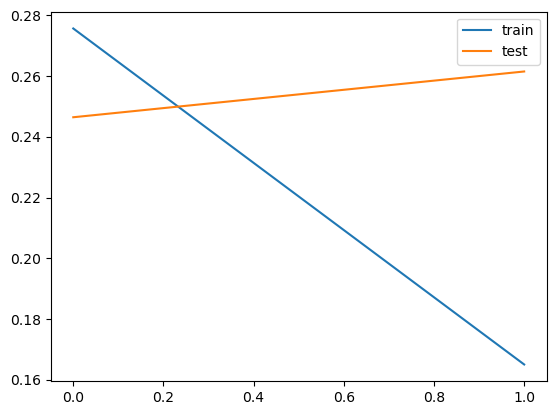

In [42]:
# plot training history

pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# evaluate the model
# _, train_acc = model.evaluate(trainX, trainy, verbose=0)
# _, test_acc = model.evaluate(testX, testy, verbose=0)
# print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# # plot training history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
# https://github.com/microsoft/AI-For-Beginners/blob/main/lessons/5-NLP/16-RNN/RNNTF.ipynb